# 주가등락예측하기(머신러닝)
과거의 데이터들로 학습을 하여 그날의 데이터로 다음의 종가는 상승할 것인지 하락할 것인지를 예측

주식관련 보조지표들과 감성분석한 데이터들을 이용하여 종목별 적합한 추세에 사용하기에 좋은 전략을 찾아내고자 한다.

In [1]:
# 기본적으로 필요한 라이브러리
import numpy as np
import pandas as pd


#시각화 라이브러리
import matplotlib.pyplot as plt 
import seaborn as sns

#datetime 형식으로 바꿔주는 라이브러리
from datetime import datetime

# 1. 시가, 고가, 저가, 종가, 거래량으로 다음 종가 등락 예측
사용 모델 : 로지스틱, lightgbm, 나이브베이즈,, knn

## - 카카오

In [8]:
stock = pd.read_csv('kakao.csv')
stock.head()

,Date,Open,High,Low,Close,Volume
0,2020-09-01,82700,83200,80000,80300,5503680
1,2020-09-02,81100,82500,80300,82400,4608275
2,2020-09-03,83100,83200,80800,82000,3696075
3,2020-09-04,78000,80900,77900,80400,5842645
4,2020-09-07,80300,80300,78200,78400,4644695


In [9]:
stock.tail()

,Date,Open,High,Low,Close,Volume
200,2021-06-24,172000,173000,155500,157000,18408195
201,2021-06-25,155000,159500,150500,154500,12271446
202,2021-06-28,154500,157500,154000,155000,5141409
203,2021-06-29,156000,158000,154500,158000,3938542
204,2021-06-30,159000,165000,157500,163000,7305590


In [10]:
stock = stock.set_index('Date') # date를 index로 설정
stock = stock.loc['2020-09-01' : '2021-06-30']

In [12]:
stock.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-06-24,172000,173000,155500,157000,18408195
2021-06-25,155000,159500,150500,154500,12271446
2021-06-28,154500,157500,154000,155000,5141409
2021-06-29,156000,158000,154500,158000,3938542
2021-06-30,159000,165000,157500,163000,7305590


## 카카오 데이터는 2020년 9월 1일부터 2021년 6월 30일까지의 데이터를 활용하여 총 205개의 데이터

## 시가, 고가, 저가, 종가, 거래량으로 Accuracy를 확인하고자 한다.

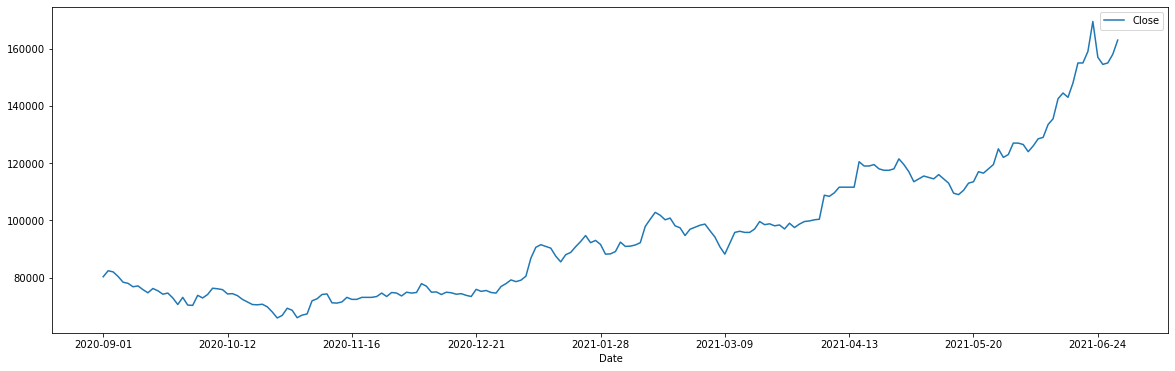

In [14]:
stock[['Close']].plot(figsize = (20,6))
plt.show()

# 1.1 머신러닝 준비
## 주식 등락을 예측하기 위해 오늘과 내일의 종가를 비교하여
## fluctuation 값 지정 - > 종가가 상승&변함이 없는 경우 1, 하락 0 

In [16]:
def up_down(x):
    if x >= 0:
        return 1
    else :
        return 0

stock['fluctuation'] = (stock['Close'].shift(-1)-stock['Close']).apply(up_down)
stock.head()

,Open,High,Low,Close,Volume,fluctuation
Date,,,,,,
2020-09-01,82700,83200,80000,80300,5503680,1
2020-09-02,81100,82500,80300,82400,4608275,0
2020-09-03,83100,83200,80800,82000,3696075,0
2020-09-04,78000,80900,77900,80400,5842645,0
2020-09-07,80300,80300,78200,78400,4644695,0


In [20]:
print('데이터 갯수 :', len(stock))

데이터 갯수 : 205


In [30]:
# 예측을 위해 7:3으로 데이터를 나누고,
# 주가는 시계열데이터로 시간의 영향이 들어갈 수 있도록 shuffle X

stock_train = stock.iloc[:-1]
target = stock_train['fluctuation']
stock_train = stock_train.drop('fluctuation', axis = 1)

from sklearn.model_selection import train_test_split
train, test, train_target, test_target = train_test_split(
    stock_train, target, test_size=0.3, shuffle=False)

In [31]:
train.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-09-01,82700,83200,80000,80300,5503680
2020-09-02,81100,82500,80300,82400,4608275
2020-09-03,83100,83200,80800,82000,3696075
2020-09-04,78000,80900,77900,80400,5842645
2020-09-07,80300,80300,78200,78400,4644695


In [32]:
test.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-06-23,162500,170000,161000,169500,9078797
2021-06-24,172000,173000,155500,157000,18408195
2021-06-25,155000,159500,150500,154500,12271446
2021-06-28,154500,157500,154000,155000,5141409
2021-06-29,156000,158000,154500,158000,3938542


# 1.2 모델링

In [49]:
# # Importing Classifier Modules
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.linear_model import LogisticRegression   # logistic
from sklearn.neighbors import KNeighborsClassifier   # knn
from sklearn.naive_bayes import GaussianNB   # naive
from lightgbm import LGBMClassifier   # lightGBM
from sklearn import datasets
from sklearn import metrics

In [50]:
# 모형 생성
import lightgbm as lgb
logistic = LogisticRegression()
knn = KNeighborsClassifier()
naive = GaussianNB()
lgb = lgb.LGBMClassifier()

models = [{'name' : 'Logistic', 'model' : logistic}, {'name' : 'KNN', 'model' : knn},
          {'name' : 'lgb.LGBM', 'model' : lgb}, {'name' : 'NaiveBayes', 'model' : naive}]

for m in models : 
    model = m['model']
    model.fit(train, train_target)
    
    predicted = model.predict(test)

#Accuracy : 전체 샘플 중 맞게 예측한 샘플수의 비율
#Precision(정밀도) : postive라고 예측한 것 중에서 실제 postive인 것
#Recall(재현율) : 실제 postive중에 예측한 postive 비율
    print ('model name : {}'.format(m['name']))
    print (metrics.classification_report(test_target, predicted))

#confusion_matrix에서
#행은 실제값, 열은 예측한 값으로 0 1 순서대로 임
    print('Confusion Matrix') 
    print (metrics.confusion_matrix (test_target, predicted))

    print ('Accuracy Score : {:.4f}\n'.format(metrics.accuracy_score(test_target, predicted)))

model name : Logistic
              precision    recall  f1-score   support

           0       0.19      0.30      0.24        20
           1       0.55      0.40      0.47        42

    accuracy                           0.37        62
   macro avg       0.37      0.35      0.35        62
weighted avg       0.43      0.37      0.39        62

Confusion Matrix
[[ 6 14]
 [25 17]]
Accuracy Score : 0.3710

model name : KNN
              precision    recall  f1-score   support

           0       0.16      0.20      0.18        20
           1       0.57      0.50      0.53        42

    accuracy                           0.40        62
   macro avg       0.36      0.35      0.35        62
weighted avg       0.44      0.40      0.42        62

Confusion Matrix
[[ 4 16]
 [21 21]]
Accuracy Score : 0.4032

model name : lgb.LGBM
              precision    recall  f1-score   support

           0       0.40      0.20      0.27        20
           1       0.69      0.86      0.77        42


In [54]:
def rate_of_return():
    df['percent'] = round((df.Close-df.Close.shift(1))/df.Close.shift(1)*100, 2)
    for i in range(len(df)-1):
        if (df.loc[i, 'predicted'] == 0):
            df.loc[i+1, 'percent'] = df.loc[i+1, 'percent']

In [55]:
for m in models : 
    model = m['model']
    model.fit(train, train_target)
    
    predicted = model.predict(test)
    
    df = pd.concat([test.reset_index().drop('Date', axis=1), pd.DataFrame(predicted, columns = ['predicted'])], axis=1)
    
    rate_of_return()
    
    df.dropna(inplace = True)

    print('model name : {}'.format(m['name']))
    print('첫날을 제외한 거래일수 : {}'.format(len(df)))
    print('누적 수익률 : {}'.format(round(df['percent'].sum(), 2)))
    print('1일 평균 수익률 : {}\n'.format(round(df['percent'].sum()/(len(df)-1),2)))

model name : Logistic
첫날을 제외한 거래일수 : 61
누적 수익률 : 48.11
1일 평균 수익률 : 0.8

model name : KNN
첫날을 제외한 거래일수 : 61
누적 수익률 : 48.11
1일 평균 수익률 : 0.8

model name : lgb.LGBM
첫날을 제외한 거래일수 : 61
누적 수익률 : 48.11
1일 평균 수익률 : 0.8

model name : NaiveBayes
첫날을 제외한 거래일수 : 61
누적 수익률 : 48.11
1일 평균 수익률 : 0.8

